# import 

In [31]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from tqdm import tqdm 
#import nglview as nv
import matplotlib
from matplotlib import cm

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rc('axes', labelsize=14)


# Functions

Undulation correction

\begin{aligned}
u (\mathbf{q}) = \frac{1}{2N} \sum_{k=1}^N \left[ z_{1k} e^{-i\mathbf{q}.\mathbf{r_{1k}}} + z_{2k} e^{-i\mathbf{q}.\mathbf{r_{2k}}} \right ]
\end{aligned}
The filter is given by:
\begin{aligned}
G(q/q_0) = \frac{1}{1+ (q/q_0)^4}
\end{aligned}

\begin{aligned}
q = 2\pi\left(\frac{m}{L_x} ,\frac{n}{L_x} \right)
\end{aligned}

The paramters $m$ and $n$ determines the range of $q$ values explored. Too high values just slows down the calculations significantly without any gain. $m$ and $n$ should be such that, the maximum value of q is higher than the filter point i.e $q_0$. The high frequency values are filtered anyway, so no point evaulvating

In [32]:
def get_fourier_coeff(box_dimensions, R_upper, R_lower, N=3, M=3, q0=1.15/10, filter=True):
    Lx, Ly = box_dimensions [0], box_dimensions [1]

    # Generate Q vectors (qx, qy) and their magnitudes
    n_vals = np.arange(-N, N+1)
    m_vals = np.arange(-M, M+1)
    n, m = np.meshgrid(n_vals, m_vals)
    n, m = n.flatten(), m.flatten()
    
    Q = np.column_stack((2 * n * np.pi / Lx, 2 * m * np.pi / Ly))
    Q = Q[np.any(Q != 0, axis=1)]  # Remove (0,0)
    
    Q_mag = np.sqrt(Q[:, 0]**2 + Q[:, 1]**2)
    
    # Precompute G
    if filter:
        G = np.sqrt(1 / (1 + (Q_mag / q0)**4))
    else: G = np.ones (len(Q_mag))
    # Combine R_upper and R_lower
    R_combined = np.vstack((R_upper, R_lower))
    
    # Extract x, y, and z components
    r_xy = R_combined[:, :2]  # x and y components
    z_combined = R_combined[:, 2]  # z component
    
    # Compute Q dot r for each Q and each r in R_combined
    Q_dot_r = np.dot(Q, r_xy.T)
    
    # Calculate the real and imaginary parts of the Fourier coefficients
    cos_QR = np.cos(Q_dot_r)
    sin_QR = np.sin(Q_dot_r)
    
    U_real = np.dot(cos_QR, z_combined)
    U_imag = -np.dot(sin_QR, z_combined)
    
    # Normalize
    norm_factor = len(R_combined)
    U_real /= norm_factor
    U_imag /= norm_factor
    
    # Combine the real and imaginary parts into complex numbers
    U = U_real + 1j * U_imag
    
    # Apply the filter
    U_filtered = G * U
    
    return Q, U_filtered


def inverse_transform(r, Q, U_filtered):
    
    Q = np.array (Q)
    # Calculate the dot product of r with each q in Q (vectorized)
    dots = np.dot(Q, r)

    # Calculate the exponential terms (vectorized)
    exp_terms = np.exp(1j * dots)

    # Compute u_tilde (vectorized)
    u_tilde = np.sum(U_filtered * exp_terms)

    # Compute delta_u_tildex and delta_u_tildey (vectorized)
    qx = Q[:, 0]
    qy = Q[:, 1]
    
    delta_u_tildex = np.sum(1j * qx * U_filtered * exp_terms)
    delta_u_tildey = np.sum(1j * qy * U_filtered * exp_terms)

    delta_u = delta_u_tildex + delta_u_tildey

    cos_theta = 1 / np.sqrt(delta_u.imag**2 + delta_u.real**2 + 1)

    return u_tilde, cos_theta

def get_different_monolayers (u, group):
    # To divide resides into bilayer leaflets, we first find the residues to which the group picked
    # for undulating reference surface belongs. Then we find the atoms with hightes and lowest 
    # z-coordinate. We use those atoms to seperate the leaftlet
    # to be sure we try both the highest z and lowest z and later on pick the atom which gives
    # most symmetric difference between the two. In most cases bothh should give same results
    res_ids          = " ".join (str (x) for x in u.select_atoms (f"name {group}").residues.resids)
    sel_top          = u.select_atoms(f"resid {res_ids}")
    
    atom_name_min    =  sel_top.names [np.argmin (sel_top.positions [:,2])]
    atom_name_max    =  sel_top.names [np.argmax (sel_top.positions [:,2])]
    
    difference = {atom_name_min:0, atom_name_max:0}
    
    for name in [atom_name_min, atom_name_max]:
        
        top_bottom_layer = u.select_atoms (f"name {name}")
        z_com            =  top_bottom_layer.center_of_mass () [2]
        
        upper_layer = np.unique(u.select_atoms (f"name {name} and prop z>{z_com}").residues.resids)
        lower_layer = np.unique(u.select_atoms (f"name {name} and prop z<{z_com}").residues.resids)
        
        difference [name] = np.abs(len (upper_layer)-len(lower_layer))
        
    ###################
    name_leaflet_boundary = min(difference, key=difference.get) 
    top_bottom_layer = u.select_atoms (f"name {name_leaflet_boundary}")
    z_com            =  top_bottom_layer.center_of_mass () [2]
    
    upper_layer = np.unique(u.select_atoms (f"name {name_leaflet_boundary} and prop z>{z_com}").residues.resids)
    lower_layer = np.unique(u.select_atoms (f"name {name_leaflet_boundary} and prop z<{z_com}").residues.resids)
    
    upper_layer_resid = " ".join (str(x) for x in upper_layer)
    lower_layer_resid = " ".join (str(x) for x in lower_layer)


    return upper_layer_resid, lower_layer_resid



def get_spectrum (u, group="C114",lipid_resname="DPPC", skip=25, dz=1, begin_frame=0, end_frame=-1, z_lim=40, q0=0.083, N=10, M=10, filter=True):
 
     
 
    membrane = u.select_atoms (f"resname {lipid_resname}")
    
    
    z_com = membrane.center_of_mass ()
    
    
    upper_resindex, lower_resindex = get_different_monolayers (u, group)
    
     
    #lower_layer = u.select_atoms ("name PO4 and prop z<%f and not resid 69 110 325 326"%z_com[2])
    
    upper_layer = u.select_atoms (f"name {group} and resid {upper_resindex}")
    lower_layer = u.select_atoms (f"name {group} and resid {lower_resindex}")  
    
    All_not_membrane = u.select_atoms (f"all and not resname {lipid_resname}")
        
 
    U_all = []
    
    for ts in tqdm (u.trajectory [begin_frame:end_frame:skip]):
            
        com_u =  upper_layer.center_of_mass ()
        com_l =  lower_layer.center_of_mass()
        
        # = (z_com_l + z_com_u )/2
    
        com_center = (com_l [2] + com_u [2] )/2
    
        pos_membrane, name_membrane =  membrane.positions , membrane.names #+  shift
         
        pos_membrane [:,2] -= com_center #  center on the center of upper an dlower leaf PO4
        
        # get upper and lower Po4 positions
        R_upper = upper_layer.positions
        R_lower = lower_layer.positions
        
        # recenter 
        R_upper [:,2] -= com_center #[2]
        R_lower [:,2] -= com_center #[2]
        
        Q, U_filtered = get_fourier_coeff (u.dimensions, R_upper, R_lower, N=N, M=M,q0=q0, filter=filter ) 

        U_all.append (U_filtered)
 
    ######################## 
    
    Q_mag = [np.sqrt (qx**2 +qy**2) for qx , qy in Q]
    
    Y = np.zeros (len(Q))
    for x in U_all:
        Y += np.abs(np.array (x))**2
    QQ=[]
    UU = []

    Y /= len (U_all)
    
    for q, u in zip(Q_mag, Y):
    
        if q in QQ: continue
        QQ.append (q)
        UU.append (u)
    
    QQ = np.array (QQ)
    UU = np.array (UU)
    sort_indices = np.argsort(QQ)
    q = QQ[sort_indices]

    return q, UU [sort_indices]
    


# Obtain the cut-off wavelength ($q_0$)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:20<00:00,  2.04it/s]


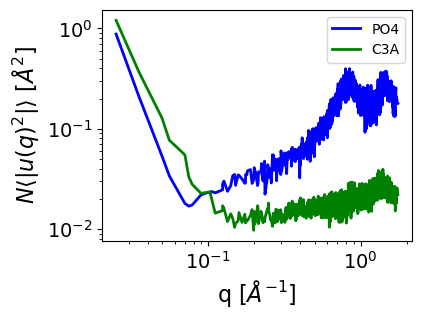

In [50]:
# Load trajectory
path="./dppc-1000/npt2/"
u = mda.Universe(path + "npt.tpr", path + "mol.xtc")

## 
# create a dictionary
# Lets use two differetn atom group to create the undulating reference surface
#We take in theis example, the phosphate bead in the head group
# and the terminal bead 
 
Spec = dict (PO4 = dict (q=[], Nq=[]),
             C3A = dict (q=[], Nq=[]))

plt.figure (figsize= (4,3))
color  = "bg"

for index, group in enumerate (Spec.keys()):
    q, Nq = get_spectrum (u,lipid_resname= "DPPC", skip=20, group=group, filter=False, N=50, M=50)
    
    Spec [group] ['q'], Spec [group]['Nq'] = q, Nq
    
    plt.loglog (q ,  Nq, label = group, ms=4, color=color[index], lw=2)

plt.xlabel ("q [$\AA^{-1}$]",fontsize=16)
plt.ylabel (r"$N \langle |u(q)^2 |\rangle~[\AA^2]$", fontsize=16)
plt.legend()

## plot

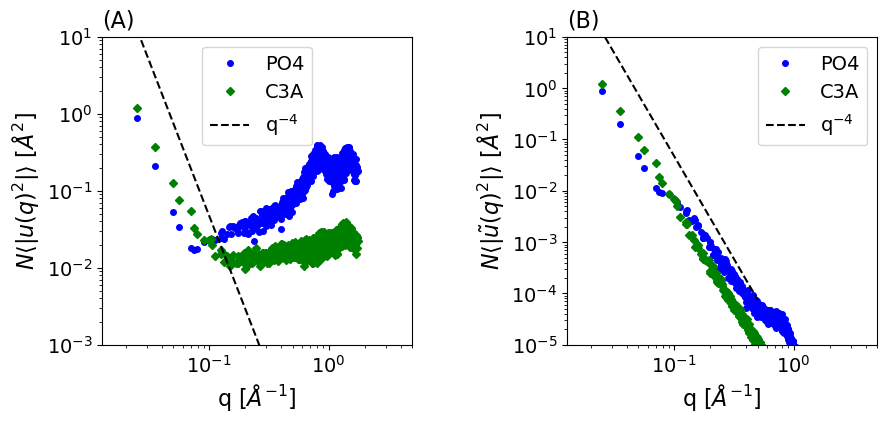

In [66]:
q0 =0.08

color  = "bg"
marker = "oD"
index = 0

#######
fig    =     plt.figure(figsize=(10,4))

gs     =     fig.add_gridspec(nrows=1, ncols=2, hspace =0.3, wspace=0.5)


ax1         =      fig.add_subplot(gs[0, 0])
ax2         =      fig.add_subplot(gs[0, 1])


for group in Spec.keys():
    
    q, Nq = np.array(Spec [group] ['q']), np.array(Spec [group]['Nq'])
    
    ax1.loglog (q ,  Nq, label = group,  marker=marker[index], ms=4, color=color[index], ls="None")
   
    G = 1 / (1 + (q / q0)**4)
    
    ax2.loglog (q ,  G*Nq, marker=marker[index], label=group, ms=4, color=color[index], ls="None")

    index += 1

#plt.yscale ("log")
#a#x1.sxscale ("log")   


q_min, q_max = 0.016, 0.5 # Define the range for the q^-4 line
q_line = np.linspace(q_min, q_max, 100)
y_line = q_line ** -4

# Optional: Scale the q^-4 line to match the data
# Adjust scaling_factor if needed for better visual comparison
scaling_factor = np.mean([Nq[np.argmin(np.abs(q - 0.02))] for group in Spec.keys()]) / np.mean(y_line)
y_line_scaled = y_line * scaling_factor

ax1.plot(q_line, y_line_scaled, linestyle='--', color='black', label=r'$\mathrm{q^{-4}}$')
ax2.plot(q_line, y_line_scaled, linestyle='--', color='black', label=r'$\mathrm{q^{-4}}$')

#ax1.set_ylim (3e-2, 0.13e1)
ax1.legend (fontsize=14)
ax2.legend (fontsize=14)
#ax2.set_ylim (3e-4, 0.13e1)
#ax2.legend (fontsize=16)
ax1.set_xlabel ("q [$\AA^{-1}$]",fontsize=16)
ax2.set_xlabel ("q [$\AA^{-1}$]",fontsize=16)
ax1.set_ylabel (r"$N \langle |u(q)^2 |\rangle~[\AA^2]$", fontsize=16)

ax2.set_ylabel (r"$N \langle |\tilde{u}(q)^2 |\rangle~[\AA^2]$", fontsize=16)

ax1.set_xlim (0,5)
ax2.set_xlim (0,5)

ax1.annotate ("(A)",fontsize=16, xycoords = "axes fraction", xy=(0.0,1.03))
ax2.annotate ("(B)",fontsize=16, xycoords = "axes fraction", xy=(0.0,1.03))
#ax1.vlines (0.04, 1e-3,1e2)
ax1.set_ylim (1e-3, 1e1)
ax2.set_ylim (1e-5, 1e1)
plt.savefig ("./sup_spectrum.png",bbox_inches="tight", dpi=300)